# Lab 3: Instacart Market Basket

## Fuente de datos

El dataset proviene de una compentencia de Kaggle (https://www.kaggle.com/c/instacart-market-basket-analysis/data). Los datos contienen información de órdenes realizadas por los usuarios en el tiempo.

## Descripción de archivos (Extraída de Kaggle)

The dataset for this competition is a relational set of files describing customers' orders over time. The dataset is anonymized and contains a sample of over 3 million grocery orders from more than 200,000 Instacart users. For each user, we provide between 4 and 100 of their orders, with the sequence of products purchased in each order. We also provide the week and hour of day the order was placed, and a relative measure of time between orders. For more information, see the blog post accompanying its public release.

Each entity (customer, product, order, aisle, etc.) has an associated unique id. Most of the files and variable names should be self-explanatory.
aisles.csv

 aisle_id,aisle  
 1,prepared soups salads  
 2,specialty cheeses  
 3,energy granola bars  
 ...

departments.csv

 department_id,department  
 1,frozen  
 2,other  
 3,bakery  
 ...

order_products__train.csv

These files specify which products were purchased in each order. 'reordered' indicates that the customer has a previous order that contains the product. Note that some orders will have no reordered items.

 order_id,product_id,add_to_cart_order,reordered  
 1,49302,1,1  
 1,11109,2,1  
 1,10246,3,0  
 ... 

orders.csv

'order_dow' is the day of week.

 order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order  
 2539329,1,prior,1,2,08,  
 2398795,1,prior,2,3,07,15.0  
 473747,1,prior,3,3,12,21.0  
 ...

products.csv

 product_id,product_name,aisle_id,department_id
 
 1,Chocolate Sandwich Cookies,61,19  
 2,All-Seasons Salt,104,13  
 3,Robust Golden Unsweetened Oolong Tea,94,7  
 ...


In [82]:
#### Cargar librerías a usar
import pandas as pd
import numpy as np
import matplotlib as plt

In [83]:
#### Carga de datos
aisles = pd.read_csv('aisles.csv')
departments = pd.read_csv('departments.csv')
order_products_prior = pd.read_csv('order_products__prior.csv')
order_products_train = pd.read_csv('order_products__train.csv')
orders_trunked = pd.read_csv('orders_trunked.csv')
orders = pd.read_csv('orders.csv')
products = pd.read_csv('products.csv')
print(aisles.head())


   aisle_id                       aisle
0         1       prepared soups salads
1         2           specialty cheeses
2         3         energy granola bars
3         4               instant foods
4         5  marinades meat preparation


In [84]:
print(departments.head())


   department_id department
0              1     frozen
1              2      other
2              3     bakery
3              4    produce
4              5    alcohol


In [85]:
order_products_prior.head()


,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [86]:
order_products_train.head()


,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [87]:
orders_trunked.head()


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [88]:
orders.head()


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [89]:
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


<AxesSubplot:xlabel='order_dow'>

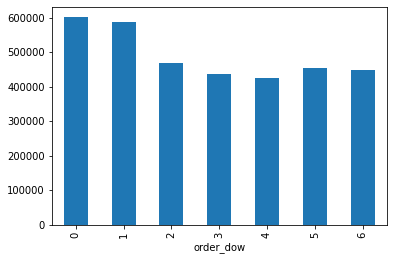

In [90]:
#### Muestra la cantidad de órdenes realizadas por día de semana (order_dow) y gráficalo usando dataframe.plot(kind='bar')
orders_by_dow = orders.groupby('order_dow')['order_dow'].count()
orders_by_dow.plot(kind='bar')

<AxesSubplot:xlabel='order_hour_of_day'>

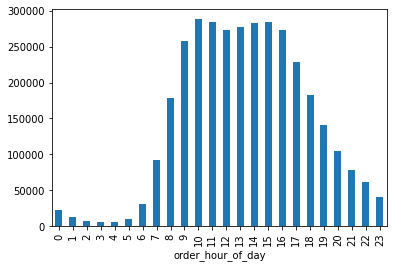

In [91]:
#### Muestra la cantidad de órdenes realizadas por hora del día (order_hour_of_day) y gráficalo usando dataframe.plot(kind='bar')
orders_per_hour_of_day = orders.groupby('order_hour_of_day')['order_hour_of_day'].count()
orders_per_hour_of_day.plot(kind='bar')


In [92]:
#### ¿Cuántos productos compra en promedio un usuario en una orden?
avg_products_per_order = order_products_train.groupby('order_id')['product_id'].count().mean()
print(f'A user orders an average of {avg_products_per_order.round()} ({avg_products_per_order} to be exact) products in each order.')

A user orders an average of 11.0 (10.552759338155157 to be exact) products in each order.


In [93]:
#### ¿Cuál es el departamento que más está presente en las órdenes?
department_orders = departments.merge(products,on="department_id").merge(order_products_train, on="product_id")[['department_id', 'department','order_id']]
department_order_count = department_orders.groupby(['department_id', 'department'])['department_id'].count()
most_frequent_department_id, most_frequent_department_name = department_order_count.idxmax()
print(f'Most frequent department is no. {most_frequent_department_id} - {most_frequent_department_name.capitalize()}')

Most frequent department is no. 4 - Produce


In [94]:
### ¿Cuáles son los mejores productos en venta?
top_selling_products = order_products_train.merge(products, on="product_id").groupby(['product_id', 'product_name'])['product_id'].count().nlargest(10).reset_index(name="count")
top_selling_products

,product_id,product_name,count
0,24852,Banana,18726
1,13176,Bag of Organic Bananas,15480
2,21137,Organic Strawberries,10894
3,21903,Organic Baby Spinach,9784
4,47626,Large Lemon,8135
5,47766,Organic Avocado,7409
6,47209,Organic Hass Avocado,7293
7,16797,Strawberries,6494
8,26209,Limes,6033
9,27966,Organic Raspberries,5546


In [95]:
#### ¿Cuáles son los productos más frecuentes reordenados?
most_frequently_reorderd_products = products.merge(order_products_train, on='product_id').groupby(['product_id', 'product_name'])['reordered'].sum().nlargest(10).reset_index()
most_frequently_reorderd_products

,product_id,product_name,reordered
0,24852,Banana,16557
1,13176,Bag of Organic Bananas,13362
2,21137,Organic Strawberries,8603
3,21903,Organic Baby Spinach,8055
4,47766,Organic Avocado,6226
5,47209,Organic Hass Avocado,6042
6,47626,Large Lemon,5923
7,16797,Strawberries,4786
8,27966,Organic Raspberries,4279
9,26209,Limes,4234
